# PROJET SCORING

## Importation des bibliothèques

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import scipy.stats as stats
from IPython.display import display
from scipy.stats import chi2_contingency
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_predict


## Lecture et aperçu des données HMEQ

In [35]:
df = pd.read_csv('hmeq.csv')
print("="*50)
print("Aperçu des premières lignes du jeu de données HMEQ :")
print("="*50)
print(df.head())
print("\n" + "="*50)
print("Informations générales sur le jeu de données :")
print("="*50)
df.info()
print("\n" + "="*50)
print("Statistiques descriptives des variables numériques :")
print("="*50)
print(df.describe())


Aperçu des premières lignes du jeu de données HMEQ :
   BAD  LOAN  MORTDUE     VALUE   REASON     JOB   YOJ  DEROG  DELINQ  \
0    1  1100  25860.0   39025.0  HomeImp   Other  10.5    0.0     0.0   
1    1  1300  70053.0   68400.0  HomeImp   Other   7.0    0.0     2.0   
2    1  1500  13500.0   16700.0  HomeImp   Other   4.0    0.0     0.0   
3    1  1500      NaN       NaN      NaN     NaN   NaN    NaN     NaN   
4    0  1700  97800.0  112000.0  HomeImp  Office   3.0    0.0     0.0   

        CLAGE  NINQ  CLNO  DEBTINC  
0   94.366667   1.0   9.0      NaN  
1  121.833333   0.0  14.0      NaN  
2  149.466667   1.0  10.0      NaN  
3         NaN   NaN   NaN      NaN  
4   93.333333   0.0  14.0      NaN  

Informations générales sur le jeu de données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
BAD        5960 non-null int64
LOAN       5960 non-null int64
MORTDUE    5442 non-null float64
VALUE      5848 non-null float64
REA

## Analyse des Distributions et des Propriétés Statistiques des Variables Numériques

In [36]:
numeric_columns = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
skewness = df[numeric_columns].skew()
kurtosis = df[numeric_columns].kurtosis()
print("="*50)
print("### Skewness (Asymétrie) des variables ###")
print("="*50)
print(skewness)
print("\n" + "="*50)
print("### Kurtosis (Aplatissement) des variables ###")
print("="*50)
print(kurtosis)

### Skewness (Asymétrie) des variables ###
LOAN       2.023781
MORTDUE    1.814481
VALUE      3.053344
YOJ        0.988460
DEROG      5.320870
DELINQ     4.023150
CLAGE      1.343412
NINQ       2.621984
CLNO       0.775052
DEBTINC    2.852353
dtype: float64

### Kurtosis (Aplatissement) des variables ###
LOAN        6.932590
MORTDUE     6.481866
VALUE      24.362805
YOJ         0.372072
DEROG      36.872763
DELINQ     23.565449
CLAGE       7.599549
NINQ        9.786507
CLNO        1.157673
DEBTINC    50.504042
dtype: float64


## Calcul du coefficient de Tschuprow entre différentes variables catégorielles

In [37]:
def tschuprow_coefficient(df, col1, col2):
    contingency_table = pd.crosstab(df[col1], df[col2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    r, c = contingency_table.shape
    tschuprow = np.sqrt(chi2 / n) / np.sqrt(min(r - 1, c - 1))

    return tschuprow
coeff_tschuprow = tschuprow_coefficient(df, 'REASON', 'JOB')
print(f"Le coefficient de Tschuprow entre REASON et JOB est : {coeff_tschuprow}")
coeff_tschuprow = tschuprow_coefficient(df, 'REASON', 'BAD')
print(f"Le coefficient de Tschuprow entre REASON et BAD est : {coeff_tschuprow}")
coeff_tschuprow = tschuprow_coefficient(df, 'BAD', 'JOB')
print(f"Le coefficient de Tschuprow entre BAS et JOB est : {coeff_tschuprow}")

Le coefficient de Tschuprow entre REASON et JOB est : 0.1490023273179537
Le coefficient de Tschuprow entre REASON et BAD est : 0.03753006571307943
Le coefficient de Tschuprow entre BAS et JOB est : 0.1200924433699837


## Analyse Visuelle des Distributions, Outliers et Normalité des Variables Numériques

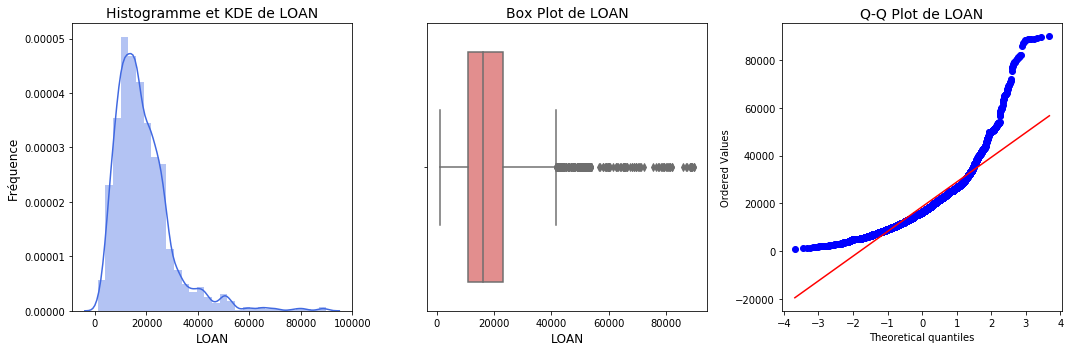

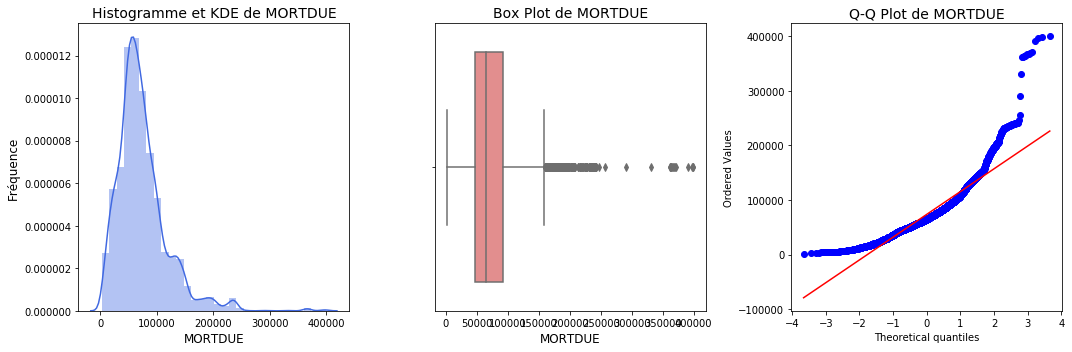

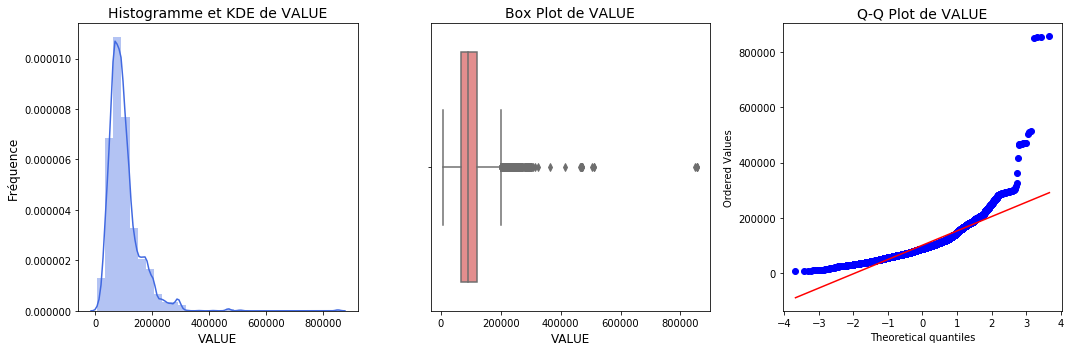

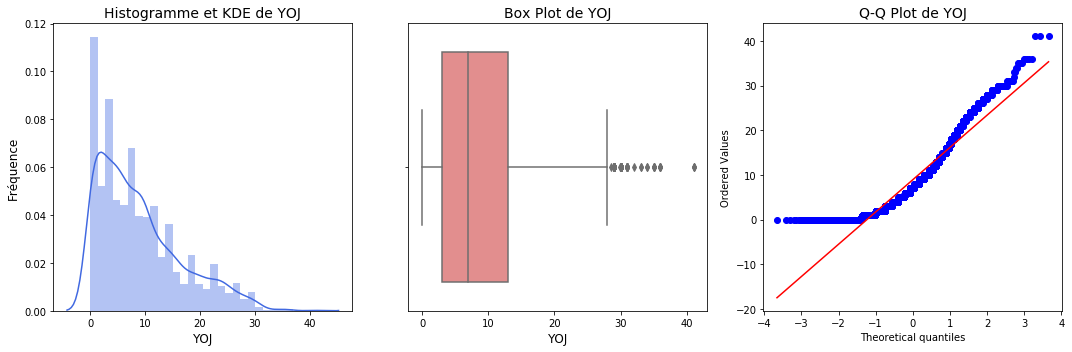

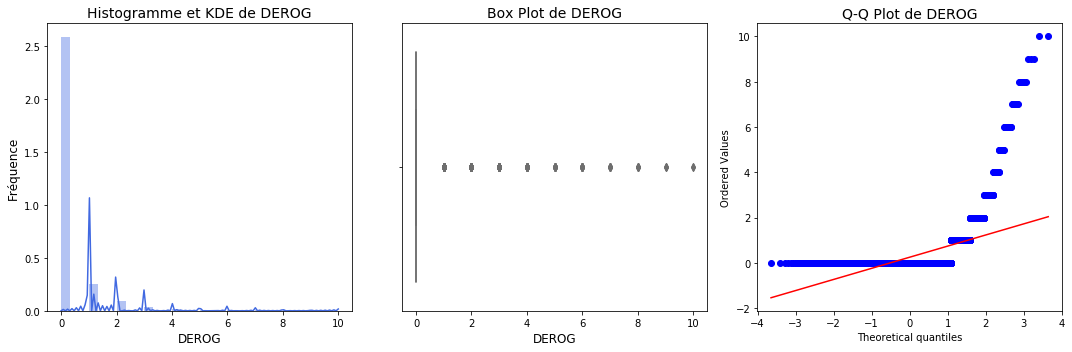

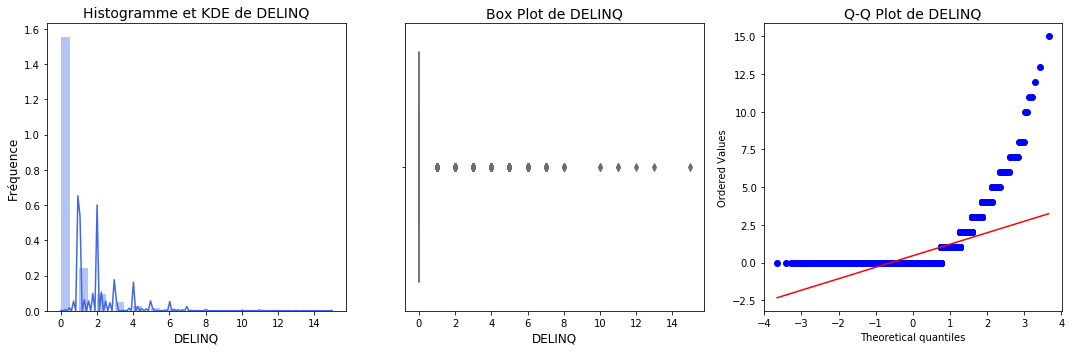

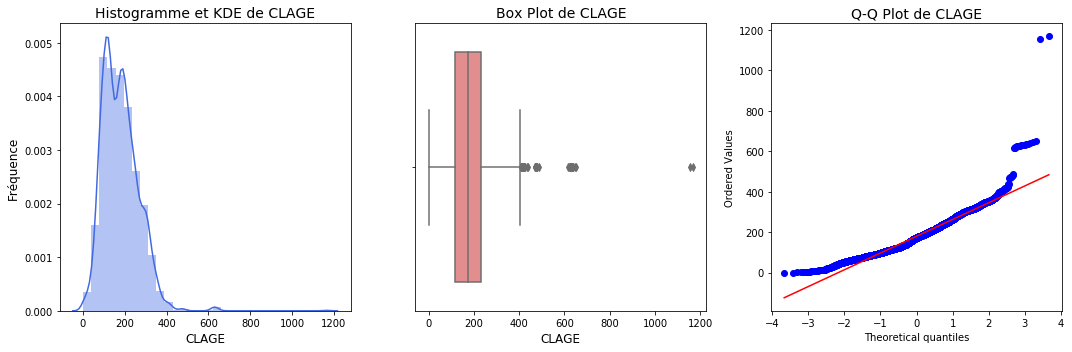

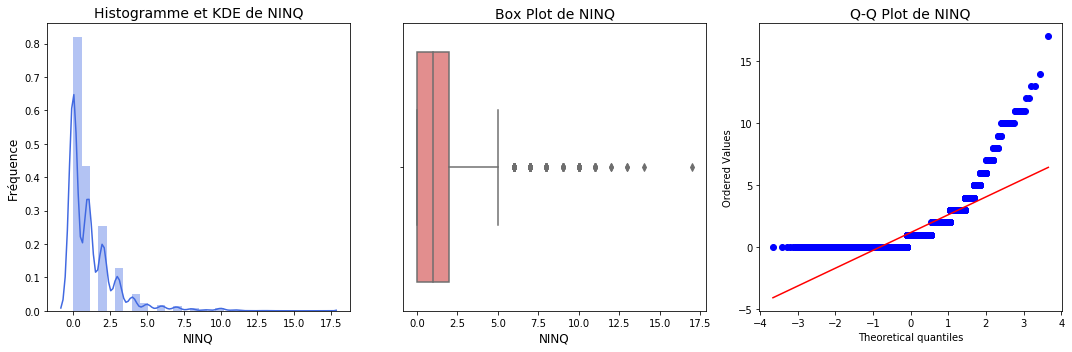

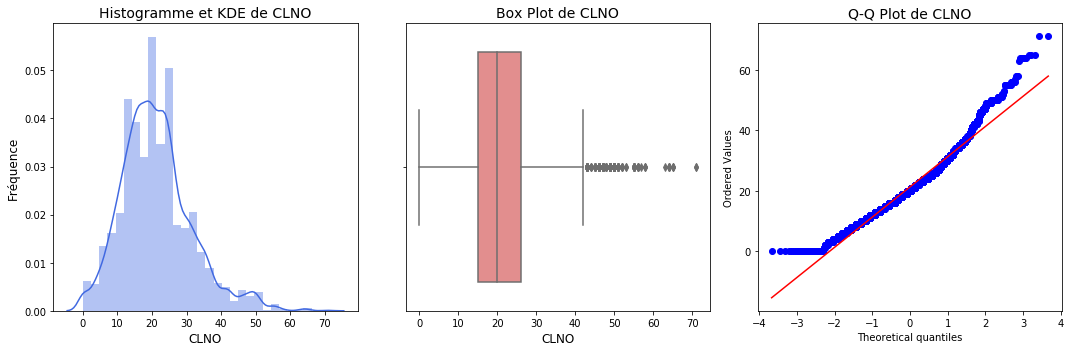

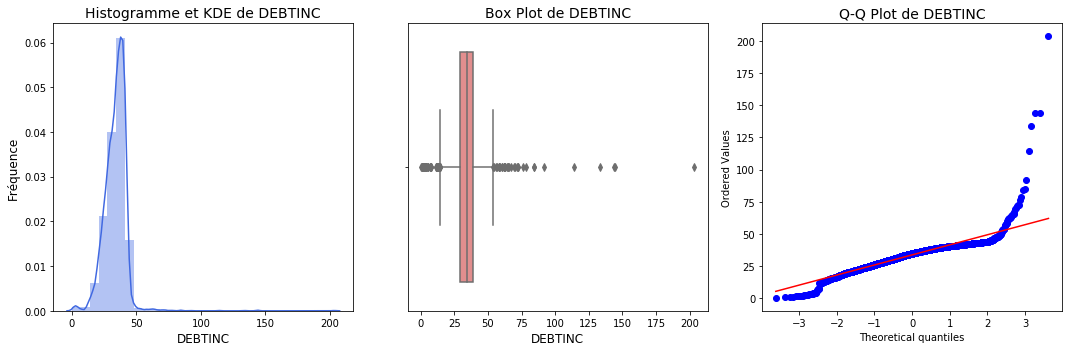

In [38]:
for col in numeric_columns:
    data = df[col].dropna()
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sns.distplot(data, kde=True, color='royalblue', bins=30)
    plt.title(f'Histogramme et KDE de {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Fréquence', fontsize=12)
    plt.subplot(1, 3, 2)
    sns.boxplot(data, color='lightcoral')
    plt.title(f'Box Plot de {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.subplot(1, 3, 3)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot de {col}', fontsize=14)
    plt.tight_layout()
    plt.show()

## Limitation des Valeurs Extrêmes par Troncature (Capping) au 99ème Percentile et Analyse Statistique

In [39]:
print("="*60)
print("### Limitation des Valeurs Extrêmes au 99ème Percentile ###")
print("="*60)

for col in numeric_columns:
    upper_limit = df[col].quantile(0.99)
    df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])
print("\n" + "="*60)
print("### Statistiques Descriptives Après Limitation des Valeurs Extrêmes ###")
print("="*60)
statistiques = df[numeric_columns].describe()
print(statistiques)

### Limitation des Valeurs Extrêmes au 99ème Percentile ###

### Statistiques Descriptives Après Limitation des Valeurs Extrêmes ###
               LOAN        MORTDUE          VALUE          YOJ        DEROG  \
count   5960.000000    5442.000000    5848.000000  5445.000000  5252.000000   
mean   18469.083893   73348.848172  100923.156505     8.900964     0.231721   
std    10540.219148   42349.225901   51730.977747     7.505444     0.685430   
min     1100.000000    2063.000000    8000.000000     0.000000     0.000000   
25%    11100.000000   46276.000000   66075.500000     3.000000     0.000000   
50%    16300.000000   65019.000000   89235.500000     7.000000     0.000000   
75%    23300.000000   91488.000000  119824.250000    13.000000     0.000000   
max    60869.000000  232230.410000  289962.800000    30.000000     4.000000   

            DELINQ        CLAGE         NINQ         CLNO      DEBTINC  
count  5380.000000  5652.000000  5450.000000  5738.000000  4693.000000  
mean     

## Analyse et Gestion des Valeurs Manquantes

### Carte des valeurs manquantes dans le Dataframe ###


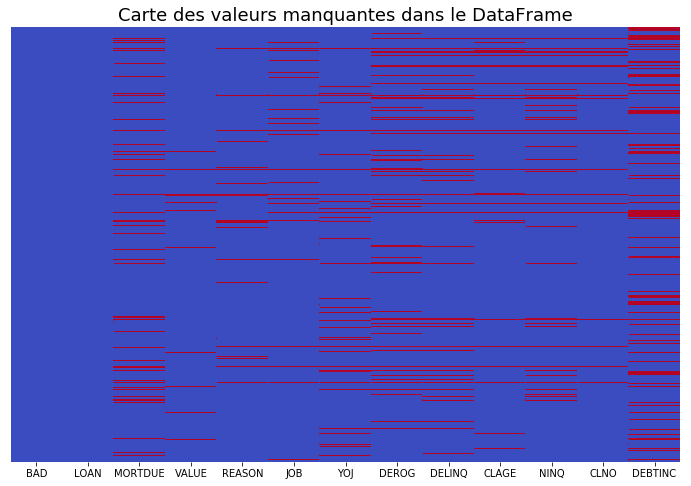

### Analyse des valeurs manquantes dans le dataset HMEQ par variable et par groupe (BAD = 1 et BAD = 0) ###

Statistiques des valeurs manquantes triées par pourcentage total de valeurs manquantes :



,Variables,Missing Values Total,Percentage Missing Total,Missing Values BAD = 1,Percentage Missing BAD = 1,Missing Values BAD = 0,Percentage Missing BAD = 0
12,DEBTINC,1267,21.2584,786,66.106,481,10.0817
7,DEROG,708,11.8792,87,7.31707,621,13.0161
8,DELINQ,580,9.73154,72,6.05551,508,10.6477
2,MORTDUE,518,8.69128,106,8.91505,412,8.63551
6,YOJ,515,8.64094,65,5.46678,450,9.43198
10,NINQ,510,8.55705,75,6.30782,435,9.11759
9,CLAGE,308,5.16779,78,6.56013,230,4.82079
5,JOB,279,4.68121,23,1.9344,256,5.36575
4,REASON,252,4.22819,48,4.03701,204,4.27583
11,CLNO,222,3.72483,53,4.45753,169,3.54223


In [40]:
print("="*60)
print("### Carte des valeurs manquantes dans le Dataframe ###")
print("="*60)
plt.figure(figsize=(12, 8))  
sns.heatmap(df.isnull(), cbar=False, cmap='coolwarm', yticklabels=False, 
            cbar_kws={'label': 'Valeurs Manquantes'})
plt.title('Carte des valeurs manquantes dans le DataFrame', fontsize=18)
plt.show()

missing_data_total = df.isnull().sum().rename_axis('Variables').reset_index(name='Missing Values Total')
missing_data_total['Percentage Missing Total'] = (missing_data_total['Missing Values Total'] / len(df)) * 100
df_bad_1 = df[df['BAD'] == 1]
missing_data_bad_1 = df_bad_1.isnull().sum().rename_axis('Variables').reset_index(name='Missing Values BAD = 1')
missing_data_bad_1['Percentage Missing BAD = 1'] = (missing_data_bad_1['Missing Values BAD = 1'] / len(df_bad_1)) * 100
df_bad_0 = df[df['BAD'] == 0]
missing_data_bad_0 = df_bad_0.isnull().sum().rename_axis('Variables').reset_index(name='Missing Values BAD = 0')
missing_data_bad_0['Percentage Missing BAD = 0'] = (missing_data_bad_0['Missing Values BAD = 0'] / len(df_bad_0)) * 100
missing_data_combined = missing_data_total.merge(missing_data_bad_1, on='Variables').merge(missing_data_bad_0, on='Variables')
missing_data_combined = missing_data_combined.sort_values(by='Percentage Missing Total', ascending=False)
print("="*80)
print("### Analyse des valeurs manquantes dans le dataset HMEQ par variable et par groupe (BAD = 1 et BAD = 0) ###")
print("="*80)
print("\nStatistiques des valeurs manquantes triées par pourcentage total de valeurs manquantes :\n")
display(missing_data_combined.style.background_gradient(cmap='coolwarm', subset=['Percentage Missing Total', 'Percentage Missing BAD = 1', 'Percentage Missing BAD = 0'])
        .set_properties(subset=['Variables'], **{'font-weight': 'bold', 'color': 'black'}))


## Suppression des lignes avec 6 valeurs manquantes ou plus

In [41]:
df = df.dropna(thresh=df.shape[1] - 6 + 1)

## Imputation des variables catégorielles 

In [43]:
df['JOB'].fillna(df['JOB'].mode()[0], inplace=True)
df['REASON'].fillna(df['REASON'].mode()[0], inplace=True)

In [44]:
df_encoded = pd.get_dummies(df, columns=['REASON', 'JOB'], drop_first=True)

## matrice de correlation 

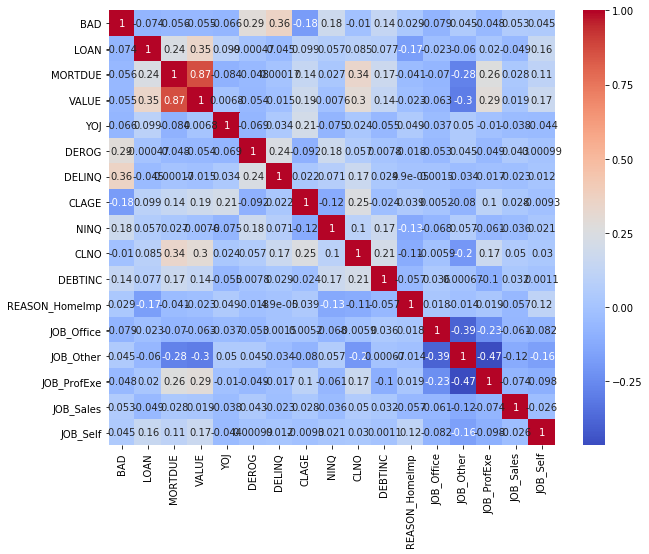

In [45]:
correlation_matrix = df_encoded.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [46]:
corr_matrix = df_encoded.corr().abs() 
threshold = 0.5
high_corr_var = corr_matrix.unstack().reset_index()
high_corr_var.columns = ['Variable_1', 'Variable_2', 'Correlation']
high_corr_var = high_corr_var[(high_corr_var['Correlation'] > threshold) & (high_corr_var['Variable_1'] != high_corr_var['Variable_2'])]
print(high_corr_var)


   Variable_1 Variable_2  Correlation
37    MORTDUE      VALUE     0.865594
53      VALUE    MORTDUE     0.865594


In [52]:
df_encoded_copy = df_encoded.copy()

In [53]:
df_cleaned = df_encoded_copy.drop(columns=['MORTDUE'])

## OPTION 1 : SUPPRIMER TOUTES LES VELEURS MANQUANTES 

In [34]:
df_cleaned1 = df_cleaned.dropna()

## Rlog pour l'option 1

In [36]:
X = df_cleaned1.drop(columns=['BAD']) 
y = df_cleaned1['BAD'] 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
logistic_model = LogisticRegression()
cv_scores = cross_val_score(logistic_model, X_scaled, y, cv=5, scoring='accuracy')
print(f"Scores de validation croisée : {cv_scores}")
print(f"Score moyen de validation croisée : {cv_scores.mean()}")

Scores de validation croisée : [ 0.91339648  0.91327913  0.91327913  0.92682927  0.92411924]
Score moyen de validation croisée : 0.9181806513599643


In [37]:
print(y.value_counts(normalize=True))

0    0.911948
1    0.088052
Name: BAD, dtype: float64


## Randomforest pour l'option 1

In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
cv_scores = cross_val_score(rf_model, X_scaled, y, cv=5, scoring='accuracy')
print(f"Scores de validation croisée : {cv_scores}")
print(f"Score moyen de validation croisée : {cv_scores.mean()}")

Scores de validation croisée : [ 0.09742896  0.93766938  0.93902439  0.92682927  0.93089431]
Score moyen de validation croisée : 0.7663692604449726


##  option 2 : Imputation des variables Num par la médiane

In [54]:
df_cleaned['VALUE'].fillna(df_cleaned['VALUE'].median(), inplace=True)
df_cleaned['DEBTINC'].fillna(df_cleaned['DEBTINC'].median(), inplace=True)
df_cleaned['CLAGE'].fillna(df_cleaned['CLAGE'].median(), inplace=True)
df_cleaned['NINQ'].fillna(df_cleaned['NINQ'].median(), inplace=True)
df_cleaned['DEROG'].fillna(0, inplace=True)  
df_cleaned['DELINQ'].fillna(0, inplace=True)  
df_cleaned['CLNO'].fillna(df_cleaned['CLNO'].median(), inplace=True)  
df_cleaned['YOJ'].fillna(df_cleaned['YOJ'].median(), inplace=True)  

## Rlog pour l'option 2 

In [55]:
X = df_cleaned.drop(columns=['BAD']) 
y = df_cleaned['BAD'] 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
logistic_model = LogisticRegression()
cv_scores = cross_val_score(logistic_model, X_scaled, y, cv=5, scoring='accuracy')
print(f"Scores de validation croisée : {cv_scores}")
print(f"Score moyen de validation croisée : {cv_scores.mean()}")

Scores de validation croisée : [ 0.8067591   0.83275563  0.84488735  0.85615251  0.84288194]
Score moyen de validation croisée : 0.836687307433083


## métriques pour RLOG option 2 

In [74]:
X = df_cleaned.drop(columns=['BAD'])
y = df_cleaned['BAD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logistic_model = LogisticRegression(class_weight='balanced')
logistic_model.fit(X_train_scaled, y_train)

y_pred_test = logistic_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test)

print(f"Accuracy : {accuracy}")
print(f"Précision : {precision}")
print(f"Rappel : {recall}")
print(f"F1-Score : {f1}")
print(f"ROC-AUC : {roc_auc}")

conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Matrice de confusion :\n", conf_matrix)


Accuracy : 0.7677642980935875
Précision : 0.4588910133843212
Rappel : 0.6685236768802229
F1-Score : 0.5442176870748299
ROC-AUC : 0.7311277276529395
Matrice de confusion :
 [[1089  283]
 [ 119  240]]


## RandomForest pour l'option 2 

In [56]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
cv_scores = cross_val_score(rf_model, X_scaled, y, cv=5, scoring='accuracy')
print(f"Scores de validation croisée : {cv_scores}")
print(f"Score moyen de validation croisée : {cv_scores.mean()}")

Scores de validation croisée : [ 0.20277296  0.85875217  0.89254766  0.89774697  0.8671875 ]
Score moyen de validation croisée : 0.7438014514731369
